In [29]:
import tensorflow as tf
import tensorflow_gnn as tfgnn
from matplotlib import pyplot as plt
import numpy as np
from importlib import reload
from sys import modules
from schema import TYPE_SPEC
from generators import load_dataset_from_data

In [30]:
reload(modules["schema"])
from schema import TYPE_SPEC
spec = TYPE_SPEC["mnist_graph"]

In [31]:
input = tf.keras.layers.Input(type_spec=spec)
gnn = tfgnn.keras.ConvGNNBuilder(
    lambda edge: tfgnn.keras.layers.SimpleConvolution(
        tf.keras.layers.Dense(128)
    ),
    lambda node: tfgnn.keras.layers.NextStateFromConcat(
        tf.keras.layers.Dense(64),
    ),
    )
hidden = gnn.Convolve()(input)
hidden = tfgnn.keras.layers.Readout(node_set_name="pixel")(hidden)
output = tf.keras.layers.Dense(10, activation="softmax")(hidden)

model = tf.keras.Model(input, output, name = "gnn")
model.summary()

Model: "gnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [()]                      0         
                                                                 
 graph_update_3 (GraphUpdate  ()                       8704      
 )                                                               
                                                                 
 readout_2 (Readout)         (784, 64)                 0         
                                                                 
 dense_2 (Dense)             (784, 10)                 650       
                                                                 
Total params: 9,354
Trainable params: 9,354
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(optimizer="adam", loss=tf.keras.losses.categorical_crossentropy, metrics=["accuracy"])

In [41]:
reload(modules["generators"])
from generators import load_dataset_from_data

(trn_img, trn_lbl), _ = tf.keras.datasets.mnist.load_data()
trn_img = trn_img/255
trn_graph = load_dataset_from_data(trn_img, trn_lbl, 1, spec)

<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
(<tensorflow_gnn.graph.graph_tensor.GraphTensor object at 0x7fce0fc1c8c0>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>)


2022-03-02 11:17:51.066582: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


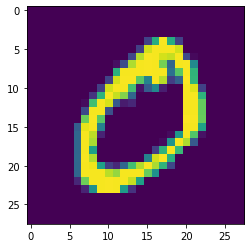

tf.Tensor(0, shape=(), dtype=int64)


In [43]:
print(type(trn_graph))
data = list(trn_graph.take(2))[1]
print(data)
plt.imshow(np.reshape(np.array(tfgnn.graph_tensor_to_values(data[0])["node_sets"]["pixel"]["hidden_state"]), (28, 28)))
plt.show()
print(data[1][0])

In [35]:
model.fit(trn_graph, epochs=10)

Epoch 1/10


ValueError: in user code:

    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/engine/training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/engine/training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/losses.py", line 1789, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/thomas/Documents/tfgnn-mnist/env/lib/python3.9/site-packages/keras/backend.py", line 5083, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (1, 1) and (784, 10) are incompatible
